Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
import matplotlib.pyplot as plt

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

First reload the data we generated in `1_notmnist.ipynb`.

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save # hint to help gc free up memory
    
    print("Training set", train_dataset.shape, train_labels.shape)
    print("Validation set", valid_dataset.shape, valid_labels.shape)
    print("Test set", test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
    # One-hot encoding
    labels = (np.arange(num_labels) == labels[:, None]).astype(np.float32)
    
    return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [4]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

### Logistic Regression

In [5]:
batch_size = 128
beta_vals = np.logspace(-4, -2, 20)
accuracy_val = []

graph = tf.Graph()

with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                      shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta_regul = tf.placeholder(tf.float32)
    
    # Variables.
    weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))
    
    # Training computation.
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels = tf_train_labels, logits = logits)) + beta_regul * tf.nn.l2_loss(weights)
    
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    # Predictions for training, validation, and test data
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

Let's run this computation and iterate:

In [6]:
num_steps = 3001

for beta_val in beta_vals:
    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()

        print("Initialized")

        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to find the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : beta_val}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)

            if step % 500 == 0:
                print("Minibatch loss at step %d: %f" % (step, l))
                print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
                print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
                
        test_accuracy = accuracy(test_prediction.eval(), test_labels)
        print("L2 regularization(beta = %.5f) test accuracy: %.1f%%\n\n" % (beta_val, test_accuracy))
        accuracy_val.append(test_accuracy)

Initialized
Minibatch loss at step 0: 20.279421
Minibatch accuracy: 5.5%
Validation accuracy: 8.7%
Minibatch loss at step 500: 1.716619
Minibatch accuracy: 77.3%
Validation accuracy: 76.0%
Minibatch loss at step 1000: 1.597043
Minibatch accuracy: 74.2%
Validation accuracy: 76.6%
Minibatch loss at step 1500: 1.250239
Minibatch accuracy: 75.8%
Validation accuracy: 78.1%
Minibatch loss at step 2000: 1.024586
Minibatch accuracy: 79.7%
Validation accuracy: 79.2%
Minibatch loss at step 2500: 1.438433
Minibatch accuracy: 70.3%
Validation accuracy: 79.0%
Minibatch loss at step 3000: 1.027863
Minibatch accuracy: 80.5%
Validation accuracy: 80.1%
L2 regularization(beta = 0.00010) test accuracy: 86.6%


Initialized
Minibatch loss at step 0: 20.222786
Minibatch accuracy: 12.5%
Validation accuracy: 15.3%
Minibatch loss at step 500: 1.946642
Minibatch accuracy: 74.2%
Validation accuracy: 75.8%
Minibatch loss at step 1000: 1.780367
Minibatch accuracy: 73.4%
Validation accuracy: 76.7%
Minibatch loss at

Minibatch loss at step 3000: 0.765864
Minibatch accuracy: 81.2%
Validation accuracy: 82.5%
L2 regularization(beta = 0.00144) test accuracy: 88.7%


Initialized
Minibatch loss at step 0: 21.685200
Minibatch accuracy: 14.8%
Validation accuracy: 14.2%
Minibatch loss at step 500: 2.897407
Minibatch accuracy: 77.3%
Validation accuracy: 77.1%
Minibatch loss at step 1000: 1.511488
Minibatch accuracy: 78.1%
Validation accuracy: 80.0%
Minibatch loss at step 1500: 0.960850
Minibatch accuracy: 79.7%
Validation accuracy: 81.8%
Minibatch loss at step 2000: 0.688438
Minibatch accuracy: 81.2%
Validation accuracy: 82.5%
Minibatch loss at step 2500: 0.938408
Minibatch accuracy: 71.9%
Validation accuracy: 82.2%
Minibatch loss at step 3000: 0.757262
Minibatch accuracy: 81.2%
Validation accuracy: 82.5%
L2 regularization(beta = 0.00183) test accuracy: 88.7%


Initialized
Minibatch loss at step 0: 23.708254
Minibatch accuracy: 9.4%
Validation accuracy: 13.5%
Minibatch loss at step 500: 2.699578
Minibatch ac

In [7]:
print("Best beta=%f, accuracy=%.1f%%" % (beta_vals[np.argmax(accuracy_val)], max(accuracy_val)))

Best beta=0.001438, accuracy=88.7%


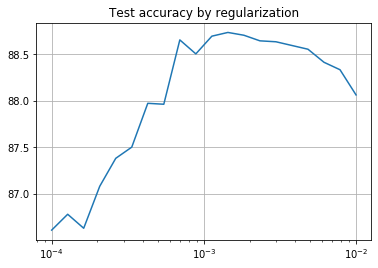

In [8]:
plt.semilogx(beta_vals, accuracy_val)
plt.grid(True)
plt.title("Test accuracy by regularization")
plt.show()

### Neural Network

In [13]:
batch_size = 128
beta_vals = np.logspace(-4, -2, 20)
hidden_size = 1024
accuracy_val = []

graph = tf.Graph()

with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                      shape=(batch_size, image_size * image_size), name='train_dataset')
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels), name='train_labels')
    tf_valid_dataset = tf.constant(valid_dataset, name='valid_dataset')
    tf_test_dataset = tf.constant(test_dataset, name='test_dataset')
    beta_regul = tf.placeholder(tf.float32, name='beta')
    
    # Variables.
    weights1 = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_size]), name='weights1')
    biases1 = tf.Variable(tf.zeros([hidden_size]), name='biases1')
    
    weights2 = tf.Variable(tf.truncated_normal([hidden_size, num_labels]), name='weights2')
    biases2 = tf.Variable(tf.zeros([num_labels]), name='biases2')
    
    # Training computation.
    hidden = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    logits = tf.matmul(hidden, weights2) + biases2
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels = tf_train_labels, logits = logits))
    loss += beta_regul * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2))
    
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    # Predictions for training, validation, and test data
    train_prediction = tf.nn.softmax(logits)
    
    valid_hidden = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    valid_prediction = tf.nn.softmax(tf.matmul(valid_hidden, weights2) + biases2)
    
    test_hidden = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    test_prediction = tf.nn.softmax(tf.matmul(test_hidden, weights2) + biases2)

In [14]:
num_steps = 3001

for beta_val in beta_vals:
    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()

        print("Initialized")

        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to find the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : beta_val}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)

            if step % 500 == 0:
                print("Minibatch loss at step %d: %f" % (step, l))
                print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
                print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
                
        test_accuracy = accuracy(test_prediction.eval(), test_labels)
        print("L2 regularization(beta = %.5f) test accuracy: %.1f%%\n\n" % (beta_val, test_accuracy))
        accuracy_val.append(test_accuracy)

Initialized
Minibatch loss at step 0: 456.162231
Minibatch accuracy: 5.5%
Validation accuracy: 27.0%
Minibatch loss at step 500: 44.605583
Minibatch accuracy: 80.5%
Validation accuracy: 80.6%
Minibatch loss at step 1000: 35.591049
Minibatch accuracy: 74.2%
Validation accuracy: 81.0%
Minibatch loss at step 1500: 37.732590
Minibatch accuracy: 79.7%
Validation accuracy: 81.3%
Minibatch loss at step 2000: 30.247379
Minibatch accuracy: 79.7%
Validation accuracy: 80.8%
Minibatch loss at step 2500: 26.160698
Minibatch accuracy: 80.5%
Validation accuracy: 82.1%
Minibatch loss at step 3000: 23.643360
Minibatch accuracy: 82.8%
Validation accuracy: 82.2%
L2 regularization(beta = 0.00010) test accuracy: 88.7%


Initialized
Minibatch loss at step 0: 386.617706
Minibatch accuracy: 5.5%
Validation accuracy: 35.3%
Minibatch loss at step 500: 55.842670
Minibatch accuracy: 78.9%
Validation accuracy: 81.2%
Minibatch loss at step 1000: 43.136940
Minibatch accuracy: 80.5%
Validation accuracy: 81.0%
Minibat

Minibatch loss at step 2500: 12.565917
Minibatch accuracy: 82.0%
Validation accuracy: 86.9%
Minibatch loss at step 3000: 6.283693
Minibatch accuracy: 88.3%
Validation accuracy: 87.0%
L2 regularization(beta = 0.00144) test accuracy: 92.8%


Initialized
Minibatch loss at step 0: 916.796814
Minibatch accuracy: 10.2%
Validation accuracy: 28.1%
Minibatch loss at step 500: 232.239334
Minibatch accuracy: 78.1%
Validation accuracy: 80.8%
Minibatch loss at step 1000: 90.988335
Minibatch accuracy: 79.7%
Validation accuracy: 82.5%
Minibatch loss at step 1500: 36.354771
Minibatch accuracy: 82.0%
Validation accuracy: 85.5%
Minibatch loss at step 2000: 14.815155
Minibatch accuracy: 85.2%
Validation accuracy: 86.8%
Minibatch loss at step 2500: 6.377484
Minibatch accuracy: 82.0%
Validation accuracy: 87.0%
Minibatch loss at step 3000: 2.777709
Minibatch accuracy: 88.3%
Validation accuracy: 87.1%
L2 regularization(beta = 0.00183) test accuracy: 92.5%


Initialized
Minibatch loss at step 0: 1047.975586
M

In [15]:
print("Best beta=%f, accuracy=%.1f%%" % (beta_vals[np.argmax(accuracy_val)], max(accuracy_val)))

Best beta=0.001438, accuracy=92.8%


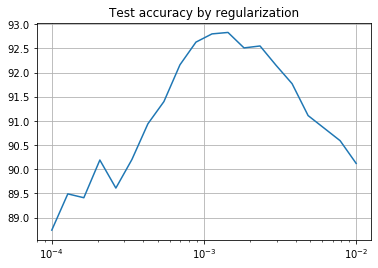

In [16]:
plt.semilogx(beta_vals, accuracy_val)
plt.grid(True)
plt.title("Test accuracy by regularization")
plt.show()

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [17]:
num_steps = 3001
smaller_train_dataset = train_dataset[:(batch_size * 5), :]
smaller_train_labels = train_labels[:(batch_size * 5)]

for beta_val in beta_vals:
    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()

        print("Initialized")

        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (smaller_train_labels.shape[0] - batch_size)
            # Generate a minibatch
            batch_data = smaller_train_dataset[offset:(offset + batch_size), :]
            batch_labels = smaller_train_labels[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to find the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : beta_val}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)

            if step % 500 == 0:
                print("Minibatch loss at step %d: %f" % (step, l))
                print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
                print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
                
        test_accuracy = accuracy(test_prediction.eval(), test_labels)
        print("L2 regularization(beta = %.5f) test accuracy: %.1f%%\n\n" % (beta_val, test_accuracy))
        accuracy_val.append(test_accuracy)

Initialized
Minibatch loss at step 0: 334.998901
Minibatch accuracy: 10.9%
Validation accuracy: 39.7%
Minibatch loss at step 500: 29.857431
Minibatch accuracy: 100.0%
Validation accuracy: 75.8%
Minibatch loss at step 1000: 28.401228
Minibatch accuracy: 100.0%
Validation accuracy: 75.9%
Minibatch loss at step 1500: 27.016052
Minibatch accuracy: 100.0%
Validation accuracy: 75.9%
Minibatch loss at step 2000: 25.698433
Minibatch accuracy: 100.0%
Validation accuracy: 75.9%
Minibatch loss at step 2500: 24.445074
Minibatch accuracy: 100.0%
Validation accuracy: 75.8%
Minibatch loss at step 3000: 23.252844
Minibatch accuracy: 100.0%
Validation accuracy: 75.9%
L2 regularization(beta = 0.00010) test accuracy: 82.6%


Initialized
Minibatch loss at step 0: 341.121765
Minibatch accuracy: 10.9%
Validation accuracy: 22.1%
Minibatch loss at step 500: 37.637810
Minibatch accuracy: 100.0%
Validation accuracy: 74.5%
Minibatch loss at step 1000: 35.314487
Minibatch accuracy: 100.0%
Validation accuracy: 74.

Minibatch loss at step 2000: 25.444748
Minibatch accuracy: 100.0%
Validation accuracy: 76.6%
Minibatch loss at step 2500: 12.396155
Minibatch accuracy: 100.0%
Validation accuracy: 77.0%
Minibatch loss at step 3000: 6.051607
Minibatch accuracy: 100.0%
Validation accuracy: 77.3%
L2 regularization(beta = 0.00144) test accuracy: 84.5%


Initialized
Minibatch loss at step 0: 915.040283
Minibatch accuracy: 12.5%
Validation accuracy: 31.0%
Minibatch loss at step 500: 230.348160
Minibatch accuracy: 100.0%
Validation accuracy: 75.3%
Minibatch loss at step 1000: 92.082222
Minibatch accuracy: 100.0%
Validation accuracy: 75.1%
Minibatch loss at step 1500: 36.810806
Minibatch accuracy: 100.0%
Validation accuracy: 75.1%
Minibatch loss at step 2000: 14.721768
Minibatch accuracy: 100.0%
Validation accuracy: 75.5%
Minibatch loss at step 2500: 5.910168
Minibatch accuracy: 100.0%
Validation accuracy: 76.4%
Minibatch loss at step 3000: 2.408621
Minibatch accuracy: 100.0%
Validation accuracy: 77.4%
L2 regu

In [18]:
print("Best beta=%f, accuracy=%.1f%%" % (beta_vals[np.argmax(accuracy_val)], max(accuracy_val)))

Best beta=0.001438, accuracy=92.8%


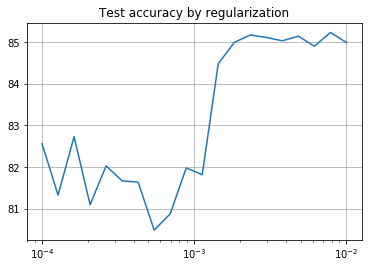

In [26]:
plt.semilogx(beta_vals, accuracy_val[20:])
plt.grid(True)
plt.title("Test accuracy by regularization")
plt.show()

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [28]:
batch_size = 128
beta_vals = np.logspace(-4, -2, 20)
hidden_size = 1024
accuracy_val = []

graph = tf.Graph()

with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                      shape=(batch_size, image_size * image_size), name='train_dataset')
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels), name='train_labels')
    tf_valid_dataset = tf.constant(valid_dataset, name='valid_dataset')
    tf_test_dataset = tf.constant(test_dataset, name='test_dataset')
    beta_regul = tf.placeholder(tf.float32, name='beta')
    
    # Variables.
    weights1 = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_size]), name='weights1')
    biases1 = tf.Variable(tf.zeros([hidden_size]), name='biases1')
    
    weights2 = tf.Variable(tf.truncated_normal([hidden_size, num_labels]), name='weights2')
    biases2 = tf.Variable(tf.zeros([num_labels]), name='biases2')
    
    # Training computation.
    hidden = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    hidden = tf.nn.dropout(hidden, rate = 0.5)
    logits = tf.matmul(hidden, weights2) + biases2
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels = tf_train_labels, logits = logits))
    loss += beta_regul * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2))
    
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    # Predictions for training, validation, and test data
    train_prediction = tf.nn.softmax(logits)
    
    valid_hidden = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    valid_prediction = tf.nn.softmax(tf.matmul(valid_hidden, weights2) + biases2)
    
    test_hidden = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    test_prediction = tf.nn.softmax(tf.matmul(test_hidden, weights2) + biases2)

In [29]:
num_steps = 3001
smaller_train_dataset = train_dataset[:(batch_size * 5), :]
smaller_train_labels = train_labels[:(batch_size * 5)]

for beta_val in beta_vals:
    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()

        print("Initialized")

        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (smaller_train_labels.shape[0] - batch_size)
            # Generate a minibatch
            batch_data = smaller_train_dataset[offset:(offset + batch_size), :]
            batch_labels = smaller_train_labels[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to find the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : beta_val}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)

            if step % 500 == 0:
                print("Minibatch loss at step %d: %f" % (step, l))
                print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
                print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
                
        test_accuracy = accuracy(test_prediction.eval(), test_labels)
        print("L2 regularization(beta = %.5f) test accuracy: %.1f%%\n\n" % (beta_val, test_accuracy))
        accuracy_val.append(test_accuracy)

Initialized
Minibatch loss at step 0: 468.151947
Minibatch accuracy: 11.7%
Validation accuracy: 39.1%
Minibatch loss at step 500: 32.208839
Minibatch accuracy: 99.2%
Validation accuracy: 76.4%
Minibatch loss at step 1000: 28.670996
Minibatch accuracy: 100.0%
Validation accuracy: 76.5%
Minibatch loss at step 1500: 27.288633
Minibatch accuracy: 100.0%
Validation accuracy: 76.8%
Minibatch loss at step 2000: 25.963497
Minibatch accuracy: 100.0%
Validation accuracy: 76.9%
Minibatch loss at step 2500: 24.701515
Minibatch accuracy: 100.0%
Validation accuracy: 77.8%
Minibatch loss at step 3000: 23.501022
Minibatch accuracy: 100.0%
Validation accuracy: 77.1%
L2 regularization(beta = 0.00010) test accuracy: 84.4%


Initialized
Minibatch loss at step 0: 509.122711
Minibatch accuracy: 10.9%
Validation accuracy: 32.2%
Minibatch loss at step 500: 37.804611
Minibatch accuracy: 100.0%
Validation accuracy: 76.6%
Minibatch loss at step 1000: 35.494335
Minibatch accuracy: 100.0%
Validation accuracy: 77.3

Minibatch loss at step 2000: 25.580290
Minibatch accuracy: 100.0%
Validation accuracy: 76.3%
Minibatch loss at step 2500: 12.460368
Minibatch accuracy: 100.0%
Validation accuracy: 76.8%
Minibatch loss at step 3000: 6.078881
Minibatch accuracy: 100.0%
Validation accuracy: 77.0%
L2 regularization(beta = 0.00144) test accuracy: 84.4%


Initialized
Minibatch loss at step 0: 1125.653564
Minibatch accuracy: 6.2%
Validation accuracy: 22.4%
Minibatch loss at step 500: 231.061554
Minibatch accuracy: 100.0%
Validation accuracy: 77.1%
Minibatch loss at step 1000: 92.419373
Minibatch accuracy: 100.0%
Validation accuracy: 77.0%
Minibatch loss at step 1500: 36.953304
Minibatch accuracy: 100.0%
Validation accuracy: 77.3%
Minibatch loss at step 2000: 14.776538
Minibatch accuracy: 100.0%
Validation accuracy: 77.2%
Minibatch loss at step 2500: 5.929855
Minibatch accuracy: 100.0%
Validation accuracy: 77.8%
Minibatch loss at step 3000: 2.416830
Minibatch accuracy: 100.0%
Validation accuracy: 78.3%
L2 regu

In [30]:
print("Best beta=%f, accuracy=%.1f%%" % (beta_vals[np.argmax(accuracy_val)], max(accuracy_val)))

Best beta=0.006158, accuracy=85.5%


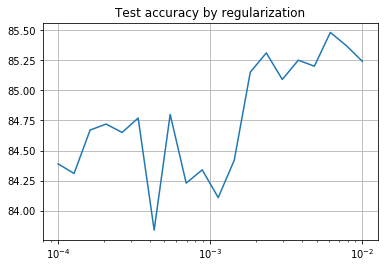

In [32]:
plt.semilogx(beta_vals, accuracy_val)
plt.grid(True)
plt.title("Test accuracy by regularization")
plt.show()

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


In [81]:
batch_size = 128
fc1_size = 4096
fc2_size = 2048
fc3_size = 128

graph = tf.Graph()
with graph.as_default():
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    tf_beta = tf.placeholder(tf.float32)
    global_step = tf.Variable(0)
    
    W1 = tf.Variable(tf.truncated_normal([image_size * image_size, fc1_size], stddev=np.sqrt(2.0 / (image_size * image_size))))
    b1 = tf.Variable(tf.zeros([fc1_size]))
    
    W2 = tf.Variable(tf.truncated_normal([fc1_size, fc2_size], stddev=np.sqrt(2.0 / (fc1_size))))
    b2 = tf.Variable(tf.zeros([fc2_size]))
    
    W3 = tf.Variable(tf.truncated_normal([fc2_size, fc3_size], stddev=np.sqrt(2.0 / (fc2_size))))
    b3 = tf.Variable(tf.zeros([fc3_size]))
    
    W4 = tf.Variable(tf.truncated_normal([fc3_size, num_labels], stddev=np.sqrt(2.0 / (fc3_size))))
    b4 = tf.Variable(tf.zeros([num_labels]))
    
    y1 = tf.nn.relu(tf.matmul(tf_train_dataset, W1) + b1)
    y2 = tf.nn.relu(tf.matmul(y1, W2) + b2)
    y3 = tf.nn.relu(tf.matmul(y2, W3) + b3)
    logits = tf.matmul(y3, W4) + b4
    
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=tf_train_labels))
    
    loss = loss + tf_beta * (tf.nn.l2_loss(W1) + tf.nn.l2_loss(b1) + tf.nn.l2_loss(W2) + tf.nn.l2_loss(b2) + 
                             tf.nn.l2_loss(W3) + tf.nn.l2_loss(b3) + tf.nn.l2_loss(W4) + tf.nn.l2_loss(b4))
    
    learning_rate = tf.train.exponential_decay(0.5, global_step, 1000, 0.7, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    
    train_predictions = tf.nn.softmax(logits)
    
    y1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, W1) + b1)
    y2_valid = tf.nn.relu(tf.matmul(y1_valid, W2) + b2)
    y3_valid = tf.nn.relu(tf.matmul(y2_valid, W3) + b3)
    valid_logits = tf.matmul(y3_valid, W4) + b4
    valid_predictions = tf.nn.softmax(valid_logits)
    
    y1_test = tf.nn.relu(tf.matmul(tf_test_dataset, W1) + b1)
    y2_test = tf.nn.relu(tf.matmul(y1_test, W2) + b2)
    y3_test = tf.nn.relu(tf.matmul(y2_test, W3) + b3)
    test_logits = tf.matmul(y3_test, W4) + b4
    test_predictions = tf.nn.softmax(test_logits)

In [83]:
num_steps = 1000

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset+batch_size), :]
        batch_labels = train_labels[offset:(offset+batch_size), :]
        
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, tf_beta: 0.001438}
        
        _, l, predictions = session.run([optimizer, loss, train_predictions], feed_dict=feed_dict)
        
        if step % 1000 == 0:
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_predictions.eval(), valid_labels))
    print("Final test accuracy: %.1f%%" % accuracy(test_predictions.eval(), test_labels))

Initialized
Minibatch loss at step 0: 9.354030
Minibatch accuracy: 8.6%
Validation accuracy: 30.6%
Final test accuracy: 92.9%
